**Calibration of spatial deterministic model** (focus on arrondissements)

Notes:
1. Based on calibration of national deterministic model found in ...
2. Includes Proximus mobility matrices
3. Includes three-fold stratified $\beta$ parameter (rural/urban/metropolitan)

# Load Python packages

In [38]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.models.utils import name2nis, save_sim, open_sim
from covid19model.data import model_parameters #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import social_policy_func, ramp_fun, lockdown_func, policies_until_september

# Download function for complete calibration
# covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [46]:
# Interaction matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = \
    model_parameters.get_interaction_matrices(spatial=agg)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)

# Add the social effect of the first lockdown
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})

0.03492

# Load all hospitalisation data per arrondissement
The model is calibrated on daily new hospitalisations (`H_in`). This data is found in the nonpublic repository.

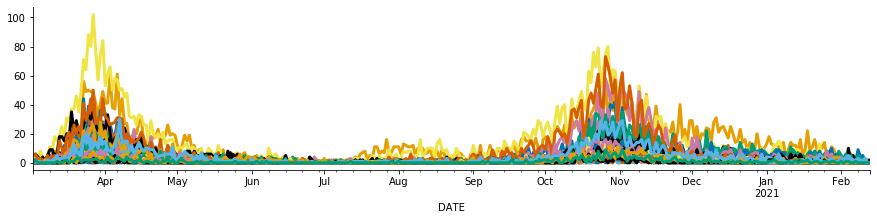

In [32]:
nonpublic_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_' + agg + '.csv'
nonpublic_ts = pd.read_csv(nonpublic_file, parse_dates=['DATE']).pivot_table(index='DATE', columns='NIS_arr', values='hospitalised_IN')

# Show all 43 time series
fig, ax = plt.subplots(figsize=(15, 3))
nonpublic_ts.plot(ax=ax)
ax.legend().remove()
ax.grid(False)

# Initialise model
The spatial model must have an initial condition

In [40]:
# Initial states: single 30 year old exposed individual in Brussels
initE = np.zeros(initN.shape)
initE[3,3] = 1
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters={'Nc': lockdown_func}, spatial=agg)